# 투자분석 hw4

20249433 최재필


In [173]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import yfinance as yf

## (a)

- MSFT
- GOOG
- KO

Source: Yahoo Finance

In [174]:
MSFT = yf.Ticker("MSFT")
GOOG = yf.Ticker("GOOG")
KO = yf.Ticker("KO")

SPY = yf.Ticker("SPY")
Tbill3M = yf.Ticker("^IRX")

In [175]:
# MSFT_df = MSFT.history(period='5y', interval='1mo')
# MSFT_ret = MSFT_df['Close'].pct_change().dropna()
# MSFT_ret = MSFT_ret.rename('MSFT')

# GOOG_df = GOOG.history(period='5y', interval='1mo')
# GOOG_ret = GOOG_df['Close'].pct_change().dropna()
# GOOG_ret = GOOG_ret.rename('GOOG')

# KO_df = KO.history(period='5y', interval='1mo')
# KO_ret = KO_df['Close'].pct_change().dropna()
# KO_ret = KO_ret.rename('KO')

# SPY_df = SPY.history(period='5y', interval='1mo')
# SPY_ret = SPY_df['Close'].pct_change().dropna()
# SPY_ret = SPY_ret.rename('SPY')

# Tbill3M_df = Tbill3M.history(period='5y', interval='1mo')
# Tbill3M_ret = Tbill3M_df['Close']
# Tbill3M_ret = Tbill3M_ret.rename('Tbill3M')
# Tbill3M_ret = Tbill3M_ret / 100 / 12 # convert to monthly rate

In [176]:
MSFT_df = MSFT.history(period='5y', interval='1mo')
MSFT_ret = MSFT_df['Close'].pct_change().dropna()
MSFT_ret = MSFT_ret.rename('MSFT')

GOOG_df = GOOG.history(period='5y', interval='1mo')
GOOG_ret = GOOG_df['Close'].pct_change().dropna()
GOOG_ret = GOOG_ret.rename('GOOG')

KO_df = KO.history(period='5y', interval='1mo')
KO_ret = KO_df['Close'].pct_change().dropna()
KO_ret = KO_ret.rename('KO')

SPY_df = SPY.history(period='5y', interval='1mo')
SPY_ret = SPY_df['Close'].pct_change().dropna()
SPY_ret = SPY_ret.rename('SPY')

Tbill3M_df = Tbill3M.history(period='5y', interval='1mo')
Tbill3M_ret = Tbill3M_df['Close']
Tbill3M_ret = Tbill3M_ret.rename('Tbill3M')
Tbill3M_ret = Tbill3M_ret / 100 / 12 # convert to monthly rate

In [177]:
MSFT_ret.index = MSFT_ret.index.to_period('M')
GOOG_ret.index = GOOG_ret.index.to_period('M')
KO_ret.index = KO_ret.index.to_period('M')
SPY_ret.index = SPY_ret.index.to_period('M')
Tbill3M_ret.index = Tbill3M_ret.index.to_period('M')

Tbill3M_ret = Tbill3M_ret.reindex(MSFT_ret.index, method='ffill')

C:\Users\chlje\AppData\Local\Temp\ipykernel_42304\452896683.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  MSFT_ret.index = MSFT_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_42304\452896683.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  GOOG_ret.index = GOOG_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_42304\452896683.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  KO_ret.index = KO_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_42304\452896683.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  SPY_ret.index = SPY_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_42304\452896683.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  Tbill3M_ret.index 

In [178]:
df = pd.concat([MSFT_ret, GOOG_ret, KO_ret, SPY_ret, Tbill3M_ret], axis=1)
df = df.dropna()

In [179]:
# Make it excess return
excs_df = df.loc[:, ['MSFT', 'GOOG', 'KO', 'SPY']].subtract(df.loc[:, 'Tbill3M'], axis=0)
excs_df.columns = [f'{ticker}_excs' for ticker in excs_df.columns]
excs_df.tail()

,MSFT_excs,GOOG_excs,KO_excs,SPY_excs
Date,,,,
2024-02,0.036042,-0.018598,0.004557,0.047834
2024-03,0.014661,0.084947,0.014991,0.025167
2024-04,-0.078981,0.076937,0.013349,-0.041709
2024-05,0.061903,0.052243,0.014414,0.046215
2024-06,-0.006448,-0.001722,-0.004367,-0.003551


In [180]:
# Remove the last row, which is the latest month. (We don't know the return of the latest month yet)
excs_df = excs_df.iloc[:-1, :].copy()

## (b)

In [181]:
stocks = ['MSFT', 'GOOG', 'KO']

def get_SIM_regression(stock_returns, market_returns, print_summary=True):
    X = sm.add_constant(market_returns)
    model = sm.OLS(stock_returns, X)
    results = model.fit()

    if print_summary:
        print(results.summary())

    return results

각 종목의 초과수익률을 시장 초과수익률에 대해 regress

In [182]:
results = {}

for stock in stocks:
    print(f'SIM regression result of {stock}')
    results[stock] = get_SIM_regression(excs_df[f'{stock}_excs'], excs_df['SPY_excs'], print_summary=True)
    print('\n'*5)

SIM regression result of MSFT
                            OLS Regression Results                            
Dep. Variable:              MSFT_excs   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     64.96
Date:                Tue, 04 Jun 2024   Prob (F-statistic):           6.16e-11
Time:                        21:42:59   Log-Likelihood:                 100.44
No. Observations:                  58   AIC:                            -196.9
Df Residuals:                      56   BIC:                            -192.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0109 

In [183]:
def get_result_values(single_stock_result):
    alpha, beta = single_stock_result.params
    t_value_alpha, t_value_beta = single_stock_result.tvalues
    p_value_alpha, p_value_beta = single_stock_result.pvalues
    r_squared = single_stock_result.rsquared

    # residual std는 따로 계산해야 함
    residuals = single_stock_result.resid
    resid_df = single_stock_result.df_resid
    residual_std = np.sqrt( (residuals**2).sum() / resid_df )

    result_values = {
        'alpha': alpha,
        'beta': beta,
        't_value_alpha': t_value_alpha,
        't_value_beta': t_value_beta,
        'p_value_alpha': p_value_alpha,
        'p_value_beta': p_value_beta,
        'r_squared': r_squared,
        'residual_std': residual_std
    }

    return result_values


In [184]:
msft_result_values = get_result_values(results['MSFT'])
goog_result_values = get_result_values(results['GOOG'])
ko_result_values = get_result_values(results['KO'])


In [185]:
msft_result_values

{'alpha': 0.010940670200662105,
 'beta': 0.8638926148627646,
 't_value_alpha': 1.873329208352305,
 't_value_beta': 8.059938877525248,
 'p_value_alpha': 0.06624524411530179,
 'p_value_beta': 6.161613006748309e-11,
 'r_squared': 0.5370470443738817,
 'residual_std': 0.043581208730610256}

In [186]:
goog_result_values

{'alpha': 0.008033249975364658,
 'beta': 1.0508440109010213,
 't_value_alpha': 1.1167088508311402,
 't_value_beta': 7.959554109302044,
 'p_value_alpha': 0.2688873789172914,
 'p_value_beta': 9.012064648960661e-11,
 'r_squared': 0.5308094856882302,
 'residual_std': 0.05368102159377001}

In [187]:
ko_result_values

{'alpha': -0.001210060208378455,
 'beta': 0.6041127990310916,
 't_value_alpha': -0.20262349918779252,
 't_value_beta': 5.511917103642034,
 'p_value_alpha': 0.8401637003477832,
 'p_value_beta': 9.320924905333164e-07,
 'r_squared': 0.35171101525244186,
 'residual_std': 0.04456425163944111}

## (c)

다음 방법을 파트 (C)에 사용할 예정입니다.

여기서의 문제는 시장 위험 프리미엄 $E[R_m]$, 그 표준 편차, 각 주식의 기대 수익률의 알파 $ \alpha_i $ 등의 예측된 값에 접근할 수 없다는 것입니다.

타임머신이 있다고 가정해보겠습니다. 우리가 2년 전으로 돌아갈 수 있다고 하면, 데이터가 2019년 8월부터 2024년 5월까지 (총 5년) 존재하므로 2022년 6월로 돌아가게 됩니다.

이 "미래" 2년치 데이터를 통해 시장 위험 프리미엄의 정확한 미래 값, 그 표준 편차, 각 주식의 기대 수익률의 알파를 추정할 수 있습니다.

이 데이터를 사용하여 최적의 위험 포트폴리오를 구성할 것입니다. 이 포트폴리오는 지수와 세 개의 주식으로 구성되며, 샤프 비율을 최대화하도록 설계될 것입니다.

### 데이터로 값 추정

In [188]:
lookahead_months = 24

excs_past_df = excs_df.iloc[:-lookahead_months, :].copy()
excs_lookahead_df = excs_df.iloc[-lookahead_months:, :].copy()

In [189]:
excs_past_df.tail()

,MSFT_excs,GOOG_excs,KO_excs,SPY_excs
Date,,,,
2022-01,-0.075489,-0.062219,0.030256,-0.049557
2022-02,-0.039439,-0.006191,0.019921,-0.029757
2022-03,0.033585,0.034866,-0.004267,0.033966
2022-04,-0.100540,-0.177423,0.049401,-0.085608
2022-05,-0.021217,-0.008926,-0.019896,0.001399


In [190]:
excs_lookahead_df.head()

,MSFT_excs,GOOG_excs,KO_excs,SPY_excs
Date,,,,
2022-06,-0.054454,-0.042254,-0.008749,-0.087740
2022-07,0.091182,0.064532,0.025483,0.094890
2022-08,-0.071023,-0.066598,-0.040719,-0.043185
2022-09,-0.110026,-0.121752,-0.094855,-0.098809
2022-10,-0.006619,-0.018809,0.072845,0.082405


"미래" (look-ahead 기간 2년치) 의 값 구하기

- market excess return 
- market excess return의 std
- alpha

In [191]:
mkt_lookahead_excs_mean = excs_lookahead_df['SPY_excs'].mean() # Market expected return (lookahead)
mkt_lookahead_excs_std = excs_lookahead_df['SPY_excs'].std() # Market expected volatility (lookahead)

mkt_lookahead_excs_mean, mkt_lookahead_excs_std

(0.009243726245208406, 0.055294922097349396)

In [192]:
lookahead_results = {}

# 미래 2년치 데이터로 regression을 돌려서 alpha 구함
for stock in stocks:
    lookahead_results[stock] = get_SIM_regression(excs_lookahead_df[f'{stock}_excs'], excs_lookahead_df['SPY_excs'], print_summary=False)


In [193]:
msft_lookahead_result_values = get_result_values(lookahead_results['MSFT'])
goog_lookahead_result_values = get_result_values(lookahead_results['GOOG'])
ko_lookahead_result_values = get_result_values(lookahead_results['KO'])

In [194]:
msft_lookahead_alpha =  msft_lookahead_result_values['alpha']
goog_lookahead_alpha =  goog_lookahead_result_values['alpha']
ko_lookahead_alpha =  ko_lookahead_result_values['alpha']

lookahead_alphas = np.array([msft_lookahead_alpha, goog_lookahead_alpha, ko_lookahead_alpha])

lookahead_alphas

array([ 0.00889626,  0.00911344, -0.0050368 ])

In [195]:
ann_msft_lookahead_alpha = msft_lookahead_alpha * 12
ann_goog_lookahead_alpha = goog_lookahead_alpha * 12
ann_ko_lookahead_alpha = ko_lookahead_alpha * 12

ann_lookahead_alphas = lookahead_alphas * 12
ann_lookahead_alphas

array([ 0.10675506,  0.10936122, -0.0604416 ])

"과거" (look-ahead 이전 기간 3년치) 의 값 구하기
- regression beta
- residual std of excess return

In [196]:
past_results = {}

# 과거 3년치 데이터로 regression을 돌려서 beta를 구함
for stock in stocks:
    past_results[stock] = get_SIM_regression(excs_past_df[f'{stock}_excs'], excs_past_df['SPY_excs'], print_summary=False)


In [197]:
msft_past_result_values = get_result_values(past_results['MSFT'])
goog_past_result_values = get_result_values(past_results['GOOG'])
ko_past_result_values = get_result_values(past_results['KO'])

In [198]:
msft_past_beta = msft_past_result_values['beta']
goog_past_beta = goog_past_result_values['beta']
ko_past_beta = ko_past_result_values['beta']

past_betas = np.array([msft_past_beta, goog_past_beta, ko_past_beta])

past_betas

array([0.86137178, 1.19913694, 0.70110948])

In [199]:
msft_past_std = excs_past_df['MSFT_excs'].std()
goog_past_std = excs_past_df['GOOG_excs'].std()
ko_past_std = excs_past_df['KO_excs'].std()

past_stds = np.array([msft_past_std, goog_past_std, ko_past_std])
past_stds

array([0.0617027 , 0.07771073, 0.06265902])

In [200]:
msft_past_resid_std = msft_past_result_values['residual_std']
goog_past_resid_std = goog_past_result_values['residual_std']
ko_past_resid_std = ko_past_result_values['residual_std']

past_resid_stds = np.array([msft_past_resid_std, goog_past_resid_std, ko_past_resid_std])

past_resid_stds

array([0.04154494, 0.04431288, 0.05090369])

In [201]:
ann_msft_past_resid_std = msft_past_resid_std * np.sqrt(12)
ann_goog_past_resid_std = goog_past_resid_std * np.sqrt(12)
ann_ko_past_resid_std = ko_past_resid_std * np.sqrt(12)

ann_past_resid_stds = past_resid_stds * np.sqrt(12)

In [202]:
sp500_past_std = excs_past_df['SPY_excs'].std()
sp500_past_std

0.0536241089337261

### 교수님 엑셀처럼 값 정리하여 optimal risky portfolio 구하기

#### $ \sigma^2(\epsilon_i) $ 

In [203]:
# msft_past_resid_var = msft_past_resid_std ** 2
# goog_past_resid_var = goog_past_resid_std ** 2
# ko_past_resid_var = ko_past_resid_std ** 2

# print(f'''
#     MSFT: {msft_past_resid_var}
#     GOOG: {goog_past_resid_var}
#     KO: {ko_past_resid_var}
#     ''')

In [204]:
# TODO: Annualized std 쓰지 않으면 마중에 weight 계산 완전완전 이상하게 나옴. 대체 왜? 
# TODO: 아니... alpha를 연율화 시켰더니 똑같이 weight 이상하게 나옴. 왜지?

msft_past_resid_var = ann_msft_past_resid_std ** 2
goog_past_resid_var = ann_goog_past_resid_std ** 2
ko_past_resid_var = ann_ko_past_resid_std ** 2

print(f'''
    MSFT: {msft_past_resid_var}
    GOOG: {goog_past_resid_var}
    KO: {ko_past_resid_var}
    ''')


    MSFT: 0.020711788198113937
    GOOG: 0.023563574322091628
    KO: 0.031094233584282434
    


In [205]:
past_resid_vars = np.array([msft_past_resid_var, goog_past_resid_var, ko_past_resid_var])

#### $ \alpha_i / \sigma^2(\epsilon_i) $

In [206]:
msft_alpha_div_resid_var = ann_msft_lookahead_alpha / msft_past_resid_var
goog_alpha_div_resid_var = ann_goog_lookahead_alpha / goog_past_resid_var
ko_alpha_div_resid_var = ann_ko_lookahead_alpha / ko_past_resid_var

print(f'''
      MSFT: {msft_alpha_div_resid_var}
      GOOG: {goog_alpha_div_resid_var}
      KO: {ko_alpha_div_resid_var}
      ''')



      MSFT: 5.154314076871453
      GOOG: 4.6411134254236694
      KO: -1.9438203804953826
      


In [207]:
alpha_div_resid_vars = np.array([msft_alpha_div_resid_var, goog_alpha_div_resid_var, ko_alpha_div_resid_var])

sum_alpha_div_resid_var = msft_alpha_div_resid_var + goog_alpha_div_resid_var + ko_alpha_div_resid_var

#### $ w_i $

In [208]:
msft_weight = msft_alpha_div_resid_var / sum_alpha_div_resid_var
goog_weight = goog_alpha_div_resid_var / sum_alpha_div_resid_var
ko_weight = ko_alpha_div_resid_var / sum_alpha_div_resid_var

print(f'''
      MSFT: {msft_weight}
      GOOG: {goog_weight}
      KO: {ko_weight}
      ''')


      MSFT: 0.6564661217651431
      GOOG: 0.5911036241915064
      KO: -0.24756974595664963
      


In [209]:
weights = np.array([msft_weight, goog_weight, ko_weight])
round(sum(weights), 10)

1.0

#### $ \alpha_A $

In [210]:
weighted_alpha = np.dot(weights, ann_lookahead_alphas)
weighted_alpha

0.14968840812450016

#### $ \beta_A $

In [211]:
weighted_beta = np.dot(weights, past_betas)
weighted_beta

1.1007020891118435

#### $ \sigma^2(\epsilon_A) $ - residual variance

여기선 약식으로 active portfolio의 variance를 그냥 가중합으로 구하고 있는 중임. 

correlation between residuals를 0으로 하기로 가정했기 때문에 이렇게 구할 수 있음. 

그렇기 때문에 SIM에서의 portfolio variance와 실제 active portfolio의 variance는 차이가 남. 

In [212]:
active_residual_var = np.dot(weights**2, past_resid_vars)
active_residual_var

0.019064683930617846

#### $ \sigma_A^2 $ - active portfolio variance


엑셀에 나온거... 수식이 맞나? 노테이션이 다른건가? ppt랑 다른거 같은데... 일단 나온 그대로 구현을 하고 나중에 확인

In [213]:
active_port_var = weighted_beta**2 * sp500_past_std**2 + active_residual_var
active_port_var

0.022548536424898742

#### $ w_A^0 $

In [214]:
w_A_0 = (weighted_alpha / active_residual_var) / (mkt_lookahead_excs_mean / mkt_lookahead_excs_std**2) # 여기서 lookahead std로 넣었다. 원래는 historical 쓰던데.
w_A_0

2.5970600167391815

#### $ w_A^* $

In [215]:
w_A_star = w_A_0 / (1 + w_A_0 * (1 - weighted_beta))
w_A_star

3.516808805310207

개별 주식 weight

In [219]:
final_weights = w_A_star * weights
final_weights

array([ 2.30866584,  2.07879843, -0.87065546])

#### $ w_M^* $

In [216]:
w_M_star = 1 - w_A_star
w_M_star

-2.516808805310207

### 그래프 확인

In [217]:
weights

array([ 0.65646612,  0.59110362, -0.24756975])

<Axes: xlabel='Date'>

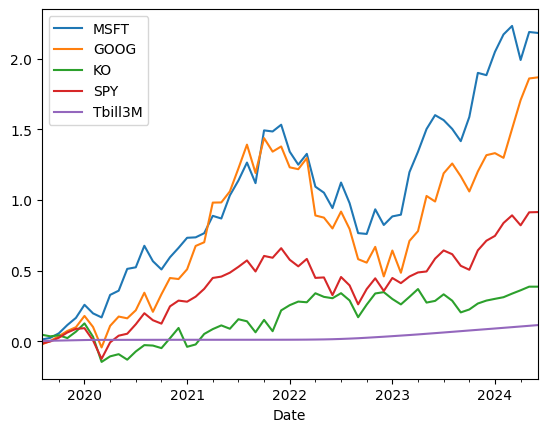

In [218]:
((1 + df).cumprod() - 1).plot()

## (d)

## (e)